In [1]:
import os
import json
import numpy as np
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from pysheds.grid import Grid
from matplotlib import colors
import seaborn as sns
import warnings
from swmm import SwmmIngester
from partition import differentiated_linear_weights, controller_placement_algorithm, naive_partition
from swmmtoolbox import swmmtoolbox
from matplotlib.lines import Line2D
from shapely import geometry, ops

warnings.filterwarnings('ignore')
sns.set_palette('husl', 8)
sns.set()

%matplotlib inline

In [2]:
grid = Grid.from_raster('../data/n30w100_dir', data_name='dir')

dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Clip the bounding box to the catchment
grid.clip_to('catch', pad=(1,1,1,1))

#Compute flow accumulation
grid.accumulation(data='catch', out_name='acc', dirmap=dirmap)

# Compute flow distance
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist', xytype='label')
dist = grid.view('dist', nodata=0, dtype=np.float64)

In [3]:
shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape)
                                     for shape, value in shapes])

In [4]:
coords = np.asarray(catchment_polygon.exterior.coords[:])

In [5]:
dist_weights = (np.where(grid.view('acc') >= 100, 0.1, 0) 
                + np.where((0 < grid.view('acc')) & (grid.view('acc') <= 100), 1, 0)).ravel()

dists = grid.flow_distance(data='catch', x=x, y=y, weights=dist_weights,
                           dirmap=dirmap, out_name='dist', xytype='label', inplace=False)

In [6]:
weights = differentiated_linear_weights(dists)
acc = grid.accumulation(data='catch', dirmap=dirmap, inplace=False)
wacc = grid.accumulation(data='catch', weights=weights, dirmap=dirmap, inplace=False)

In [7]:
with open('../data/experiments_differentiated_50pct_phi10.json', 'r') as infile:
    experiments = json.load(infile)

In [8]:
output_dir = '../data/out'

var = {}
maxes = {}

for experiment in experiments:
    if ('phi10' in experiment) or ('naive' in experiment) or ('uncontrolled' in experiment):
        fn = '{0}_diff_1.5in.out'.format(experiment)
        if fn in os.listdir(output_dir):
            outfall = swmmtoolbox.extract('../data/out/{0}'.format(fn), 'system,Flow_leaving_outfalls,11')
            var[experiment] = outfall.var()[0]
            maxes[experiment] = outfall.max()[0]
            
var = pd.Series(var).sort_values()
maxes = pd.Series(maxes).sort_values()

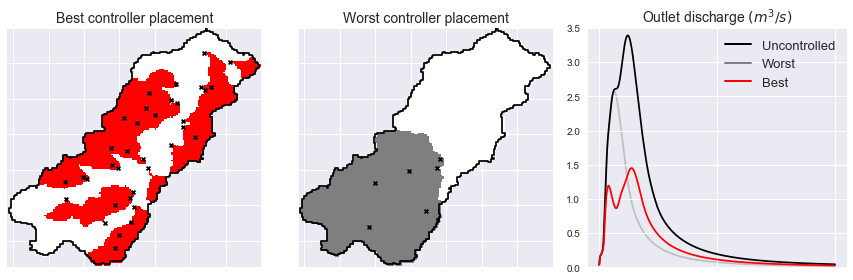

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

tot_weights = {}
out_arr = np.zeros(grid.shape)

cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

best = 'linear_k35_50pct_phi10'
worst = var.index[-1]

for loc in experiments[best]['controller_locs']:
    y, x = np.unravel_index(loc, grid.shape)
    xx, yy = grid.affine * (x, y)
    ax[0].scatter(xx, yy, zorder=4, c='k', s=15, marker='x')
    out_arr += grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, inplace=False,
                              recursionlimit=15000, xytype='index').astype(bool)

ax[0].imshow(np.where(out_arr, 1, 0) + np.where(grid.mask, 1, np.nan), zorder=1,
             cmap=cmap, norm=norm, extent=grid.extent)
ax[0].set_title('Best controller placement', size=14)
ax[0].plot(coords[:, 0] + grid.cellsize / 2, coords[:, 1], color='k')

cmap = colors.ListedColormap(['white', '0.5'])
bounds=[0,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

out_arr = np.zeros(grid.shape)

for loc in experiments[worst]['controller_locs']:
    y, x = np.unravel_index(loc, grid.shape)
    xx, yy = grid.affine * (x, y)
    ax[1].scatter(xx, yy, zorder=4, c='k', s=15, marker='x')
    out_arr += grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, inplace=False,
                              recursionlimit=15000, xytype='index').astype(bool)
    
ax[1].imshow(np.where(out_arr, 1, 0) + np.where(grid.mask, 1, np.nan), zorder=1,
             cmap=cmap, norm=norm, extent=grid.extent)
ax[1].set_title('Worst controller placement', size=14)
ax[1].plot(coords[:, 0], coords[:, 1], color='k')

outfall = swmmtoolbox.extract('../data/out/uncontrolled_diff_1.5in.out', 'system,Flow_leaving_outfalls,11')
outfall.plot(ax=ax[2], legend=False, color='k', zorder=1)

outfall = swmmtoolbox.extract('../data/out/{0}_diff_1.5in.out'.format(best), 'system,Flow_leaving_outfalls,11')
outfall.plot(ax=ax[2], legend=False, color='r', zorder=2)
                
outfall = swmmtoolbox.extract('../data/out/{0}_diff_1.5in.out'.format(worst), 'system,Flow_leaving_outfalls,11')
outfall.plot(ax=ax[2], legend=False, color='0.75', alpha=1, zorder=0)

custom_lines = [Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='0.5', lw=2),
                Line2D([0], [0], color='r', lw=2)]

ax[2].set_title('Outlet discharge $(m^3/s)$', size=14)
ax[2].legend(custom_lines, ['Uncontrolled', 'Worst', 'Best'], loc=1, fontsize=13)
ax[2].get_xaxis().set_ticklabels([])
ax[2].minorticks_off()

ax[0].get_xaxis().set_ticklabels([])
ax[0].get_yaxis().set_ticklabels([])
ax[1].get_xaxis().set_ticklabels([])
ax[1].get_yaxis().set_ticklabels([])
ax[2].set_ylim(0, 3.5)

plt.tight_layout()
plt.savefig('../img/placement_visualization.png', bbox_inches='tight', dpi=200)

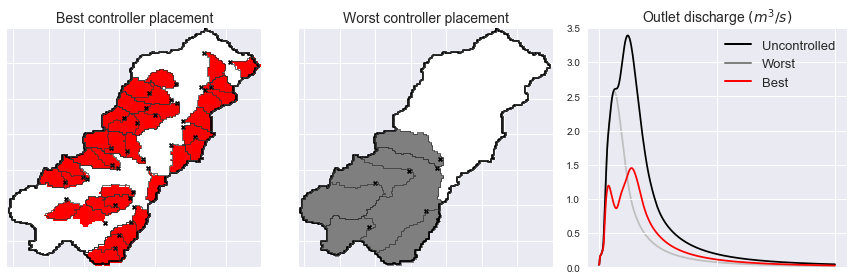

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

tot_weights = {}
out_arr = np.zeros(grid.shape)

cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

for loc in experiments[best]['controller_locs']:
    y, x = np.unravel_index(loc, grid.shape)
    xx, yy = grid.affine * (x, y)
    ax[0].scatter(xx, yy, zorder=4, c='k', s=15, marker='x')
    newcatch = grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, inplace=False,
                              recursionlimit=15000, xytype='index').astype(bool)
    out_arr += newcatch
    p = grid.polygonize(newcatch.astype(np.uint8), transform=grid.affine)
    shapes = [geometry.shape(i) for i, j in p]
    outline = shapes[0]
    subxy = outline.exterior.coords.xy
    ax[0].plot(subxy[0] + grid.cellsize / 2, subxy[1] + grid.cellsize / 2, color='0.2', linewidth=0.7, zorder=4)

ax[0].imshow(np.where(out_arr, 1, 0) + np.where(grid.mask, 1, np.nan), zorder=1, cmap=cmap, norm=norm, extent=grid.extent)
ax[0].set_title('Best controller placement', size=14)
ax[0].plot(coords[:, 0], coords[:, 1], color='k')

cmap = colors.ListedColormap(['white', '0.5'])
bounds=[0,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

out_arr = np.zeros(grid.shape)

for loc in experiments[var.index[-1]]['controller_locs']:
    y, x = np.unravel_index(loc, grid.shape)
    xx, yy = grid.affine * (x, y)
    ax[1].scatter(xx, yy, zorder=4, c='k', s=15, marker='x')
    newcatch = grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, inplace=False,
                              recursionlimit=15000, xytype='index').astype(bool)
    out_arr += newcatch
    p = grid.polygonize(newcatch.astype(np.uint8), transform=grid.affine)
    shapes = [geometry.shape(i) for i, j in p]
    outline = shapes[0]
    subxy = outline.exterior.coords.xy
    ax[1].plot(subxy[0] + grid.cellsize / 2, subxy[1] + grid.cellsize / 2, color='0.2', linewidth=0.7, zorder=4)
    
ax[1].imshow(np.where(out_arr, 1, 0) + np.where(grid.mask, 1, np.nan), zorder=1, cmap=cmap, norm=norm, extent=grid.extent)
ax[1].set_title('Worst controller placement', size=14)
ax[1].plot(coords[:, 0], coords[:, 1], color='k')

outfall = swmmtoolbox.extract('../data/out/uncontrolled_diff_1.5in.out', 'system,Flow_leaving_outfalls,11')
outfall.plot(ax=ax[2], legend=False, color='k', zorder=1)

outfall = swmmtoolbox.extract('../data/out/{0}_diff_1.5in.out'.format(best), 'system,Flow_leaving_outfalls,11')
outfall.plot(ax=ax[2], legend=False, color='r', zorder=2)
                
outfall = swmmtoolbox.extract('../data/out/{0}_diff_1.5in.out'.format(var.index[-1]), 'system,Flow_leaving_outfalls,11')
outfall.plot(ax=ax[2], legend=False, color='0.75', alpha=1, zorder=0)

custom_lines = [Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='0.5', lw=2),
                Line2D([0], [0], color='r', lw=2)]

ax[2].set_title('Outlet discharge $(m^3/s)$', size=14)
ax[2].legend(custom_lines, ['Uncontrolled', 'Worst', 'Best'], loc=1, fontsize=13)
ax[2].get_xaxis().set_ticklabels([])
ax[2].minorticks_off()

ax[0].get_xaxis().set_ticklabels([])
ax[0].get_yaxis().set_ticklabels([])
ax[1].get_xaxis().set_ticklabels([])
ax[1].get_yaxis().set_ticklabels([])
ax[2].set_ylim(0, 3.5)

plt.tight_layout()